In [1]:
"""
Copyright 2021 Huawei Technologies Co., Ltd

CREATED:  2022-12-14 16:10:30
MODIFIED: 2022-12-28 18:50:15
"""

# -*- coding:utf-8 -*-
import acl
import cv2
from PIL import Image, ImageDraw
import sys
# define acllite library path
sys.path.append('../../Common/acllite')
# modules of acllite library
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource
from src.model import preprocessing, postprocessing

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# define device id & model path
device_id = 0
model_path = "model/yolov7.om"

# define image & coco_names paths
image_path = "data/kite.jpg"
coco_names_path = "data/coco.names"

In [4]:
with open(coco_names_path) as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][0:]

In [5]:
# initialize acllite library
acl_resource = AclLiteResource()
acl_resource.init()

# load *.om model
model = AclLiteModel(model_path, device_id)

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 34272000
Create model output dataset success
Init model resource success


In [6]:
# Read image
img_org_bgr = cv2.imread(image_path)
# store original image sizes for postprocessing
height_original, width_original, _ = img_org_bgr.shape

In [7]:
# 1) pre-processing stage
data,img_resized,w,h = preprocessing(img_org_bgr,model._model_desc)

model input size 1
input  0
model input dims ({'name': 'images', 'dimCount': 4, 'dims': [1, 3, 1280, 1280]}, 0)
model input datatype 0
model output size 1
output  0
model output dims ({'name': '/model.105/Concat_3:0:output', 'dimCount': 3, 'dims': [1, 100800, 85]}, 0)
model output datatype 0
[Model] class Model init resource stage success
model_h,model_w 1280 1280
resized (630, 946, 3)
transpose (3, 1280, 1280)
cont array (3, 1280, 1280)


In [8]:
%timeit -n 10 -r 3
# 2) model execution(forward) stage
result_list = model.execute([data,]) 

In [9]:
# 3) post-processing the raw predictions
bboxes = postprocessing(result_list[0],img_resized,w,h)

In [10]:
img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
img1 = ImageDraw.Draw(img)

for bbox in bboxes:
    img1.rectangle(list(bbox[:4]), outline ="red", width=1)
    print(bbox[:4], bbox[4], bbox[5], coco_labels[int(bbox[5])])

[107.0, 871.0, 157.0, 1086.0] 0.9189453 0 person
[204.0, 994.0, 256.0, 1216.0] 0.9160156 0 person
[561.0, 114.0, 635.0, 217.0] 0.9151211 33 kite
[265.0, 337.0, 290.0, 401.0] 0.8760967 33 kite
[1026.0, 561.0, 1042.0, 602.0] 0.8734102 33 kite
[442.0, 483.0, 460.0, 511.0] 0.8263407 33 kite
[78.0, 723.0, 99.0, 806.0] 0.82128906 0 person
[546.0, 491.0, 568.0, 527.0] 0.8162737 33 kite
[167.0, 769.0, 182.0, 816.0] 0.7626953 0 person
[286.0, 534.0, 309.0, 585.0] 0.72536516 33 kite
[329.0, 693.0, 337.0, 717.0] 0.7160969 0 person
[36.0, 725.0, 52.0, 800.0] 0.7102432 0 person
[19.0, 755.0, 37.0, 793.0] 0.70947266 0 person
[493.0, 719.0, 505.0, 758.0] 0.6899414 0 person
[504.0, 732.0, 523.0, 760.0] 0.60058594 0 person


In [11]:
img = img.resize((width_original,height_original))

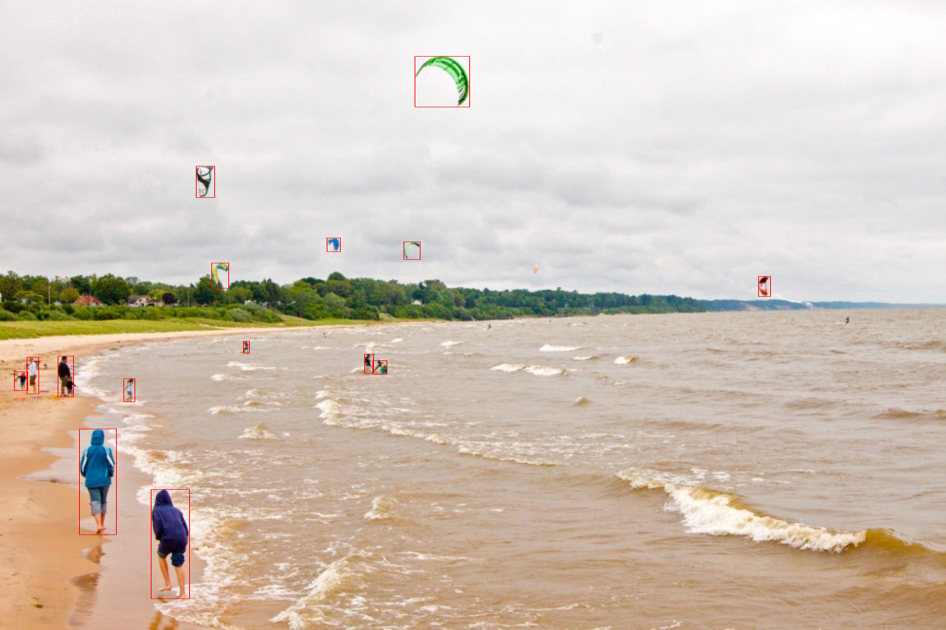

In [12]:
img